In [197]:
import numpy as np
from datetime import datetime, timedelta
import pandas as pd

In [198]:
def heston(S0=100, V0=0.05, mu=0.1, kappa=0.3, theta=0.05, xi=0.05, rho=0.2,
           start_time=datetime(2010, 1, 1), end_time=datetime(2024, 12, 1), dt=1/365, dt_date=timedelta(days=1),
           volume=True, mu_volume=4, sigma_volume=1):
    S = [S0]
    D = [start_time]
    V = [V0]
    while start_time + dt_date < end_time:
        z1 = np.random.normal()
        z2 = np.random.normal()
        dw_s = np.sqrt(dt) * z1
        dw_v = np.sqrt(dt) * (rho * z1 + np.sqrt(1 - rho**2) * z2)
        sigma = V[-1] + kappa * (theta - V[-1]) * dt + xi * np.sqrt(V[-1]) * dw_v
        V.append(sigma)
        s = S[-1] * np.exp((mu - 0.5 * V[-1]) * dt + np.sqrt(V[-1]) * dw_s)
        S.append(s)
        start_time += dt_date
        D.append(start_time)

    if volume:

        return pd.DataFrame({
            "price": S,
            "volatility": V,
            "volume": np.random.lognormal(mu_volume, sigma_volume, len(S))
        }, index=D)

    return pd.DataFrame({
            "price": S,
            "volatility": V
        }, index=D)

def multi_heston(N=10,
            S0=100, V0=0.05, mu=0.1, kappa=0.3, theta=0.05, xi=0.05, rho=0.2,
           start_time=datetime(2010, 1, 1), end_time=datetime(2024, 12, 1), dt=1/365, dt_date=timedelta(days=1),
           volume=True, mu_volume=4, sigma_volume=1):
    
    res = []
    for _ in range(N):
        data = heston(S0, V0, mu, kappa, theta, xi, rho, start_time, end_time, dt, dt_date, volume, mu_volume, sigma_volume)
        res.append(data)
    return res



In [199]:
from scipy.special import logsumexp
from scipy.stats import multivariate_normal

def forward(loga, logb, T, M, logpi):
    logalpha = np.empty((T, M))
    for i in range(M):
        logalpha[0, i] = logpi[i] + logb[0, i]
    for t in range(1, T):
        for j in range(M):
            logterms = [loga[i, j] + logalpha[t - 1, i] for i in range(M)]
            logalpha[t, j] = logsumexp(logterms) + logb[t, j]
        
    return logalpha

def backward(loga, logb, T, M):
    logbeta = np.empty((T, M))
    logbeta[T - 1, :] = 0
    for t in range(T - 2, -1, -1):
        for i in range(M):
            logterms = [loga[i, j] + logb[t + 1, i] + logbeta[t + 1, j] for j in range(M)]
            logbeta[t, i] = logsumexp(logterms)
            
    return logbeta

def compute_gamma(logalpha, logbeta, T, M):
    loggamma = np.empty((T, M))
    for t in range(T):
        for i in range(M):
            loggamma[t, i] = logalpha[t, i] + logbeta[t, i] - logsumexp([
                logalpha[t, j] + logbeta[t, j] for j in range(M)
            ])

    return loggamma

def compute_xi(logalpha, logbeta, loga, logb, T, M):
    xi = np.empty((T, M, M))
    for t in range(T - 1):
        for i in range(M):
            for j in range(M):
                logterms = []
                for k in range(M):
                    for l in range(M):
                        logterms.append(
                            logalpha[t, k] + loga[k, l] + logb[t + 1, l] + logbeta[t + 1, l]
                        )
                xi[t, i, j] = (
                    logalpha[t, i] + loga[i, j] + logb[t + 1, j] + logbeta[t + 1, j]
                    - logsumexp(logterms)
                )
    return xi

def compute_a(loggamma, logxi, T, M):
    loga = np.empty((M, M))
    for i in range(M):
        for j in range(M):
            loga[i, j] = (
                logsumexp([logxi[t, i, j] for t in range(T - 1)])
                - logsumexp([loggamma[t, i] for t in range(T - 1)])
            )
    return loga

def compute_b(mus, Sigmas, dataset, T, M):
    """
    mus: M x N mean returns (over time) per regime and asset
    Sigmas: M x N x N the covariance matrix per regime
    dataset: T x N matrix of returns

    returns: logB, T x M, where logB[t,k] = log p(r_t | s_t = k)
    """

    logb = np.empty((T, M))
    for t in range(T):
        for k in range(M):
            if np.isnan(dataset[t, :]).any() or np.isnan(mus[k, :]).any() or np.isnan(Sigmas[k, :, :]).any():
                print('NAN VALUES:')
                print(dataset[t, :])
                print()
                print(mus[k, :])
                print()
                print(Sigmas[k, :, :])
                raise AssertionError()
            logb[t, k] = multivariate_normal.logpdf(dataset[t, :], mus[k, :], Sigmas[k, :, :])
    return logb

def compute_mus_sigmas(loggamma, dataset, T, M, N, eps=1e-04):
    mus = np.empty((M, N))
    Sigmas = np.empty((M, N, N))
    for m in range(M):
        exp_gammas = np.empty(T)

        # compute mus
        exp_gammas = np.exp(loggamma[:, m])
        den = exp_gammas.sum()
        if den < eps:
            # State got no responsibility → reinitialize it
            mus[m, :] = np.mean(dataset, axis=0) + np.random.normal(0, 0.01, size=N)
            Sigmas[m, :, :] = np.cov(dataset.T) + eps * np.eye(N)
            continue
        
        mus[m, :] = np.sum(exp_gammas[:, None] * dataset, axis=0) / den

        # compute Sigmas
        # covariance
        diffs = dataset - mus[m, :]
        Sigmas[m, :, :] = (diffs.T @ (diffs * exp_gammas[:, None])) / den

        # stabilize
        Sigmas[m, :, :] = (Sigmas[m, :, :] + Sigmas[m, :, :].T) / 2
        Sigmas[m, :, :] += eps * np.eye(N)

    return mus, Sigmas

    

                   0         1         2         3         4
2010-01-02  0.006217  0.001974  0.003978  0.007435  0.007064
2010-01-03  0.013638 -0.000941  0.008885  0.008863  0.008726
2010-01-04  0.004757 -0.027729  0.020712 -0.003683  0.000656
2010-01-05  0.014417 -0.032450  0.008801  0.000353  0.014586
2010-01-06  0.001289 -0.026693  0.011081  0.007797  0.034532
...              ...       ...       ...       ...       ...
2024-11-26  5.116686  0.250042  0.232329  3.702830  4.699151
2024-11-27  4.915694  0.226421  0.229185  3.671895  4.663468
2024-11-28  4.847187  0.220684  0.246702  3.642280  4.798842
2024-11-29  5.011661  0.231607  0.258384  3.644219  4.869687
2024-11-30  4.992962  0.258270  0.260746  3.662694  4.898429

[5447 rows x 5 columns]


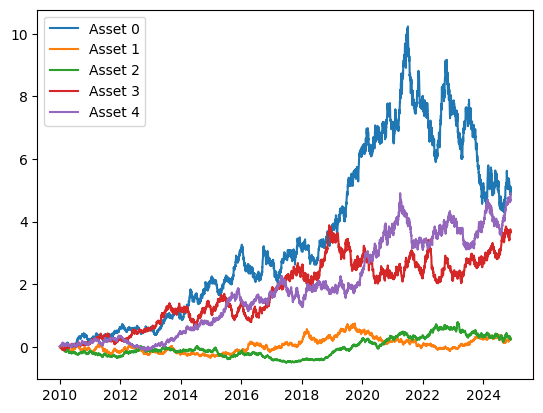

In [200]:
import matplotlib.pyplot as plt

N = 5 # number of assets in portfolio
M = 3 # number of regimes (states)

returns = []
volatilities = []

data = multi_heston(N)
for dataset in data:
    returns.append(dataset["price"].pct_change().values.tolist())
    volatilities.append(dataset["volatility"].values.tolist())

returns = pd.DataFrame(np.array(returns).T[1:, :], index=data[0].index[1:], columns=list(range(N)))
cum_returns = pd.DataFrame((1 + returns).cumprod(axis=0) - 1, index=data[0].index[1:], columns=list(range(N)))
volatilities = pd.DataFrame(np.array(volatilities).T[1:, :], index=data[0].index[1:], columns=list(range(N)))
print(cum_returns)

T = returns.shape[0] # amount of timestamps

fig, ax = plt.subplots()
for i in range(N):
    ax.plot(cum_returns.index, cum_returns[i], label=f"Asset {i}")

ax.legend()
plt.show()

In [201]:
def k_means(data, k):
    # data: np-array of vectors (points), shape (n_vectors, vector_dim)
    # k: amount of clusters

    # data size: (n_points, vector_dim)

    center_indices = np.random.randint(0, len(data), size=(1,k)) # (1, k)
    centers = np.array([data[i] for i in center_indices]).reshape((k, data.shape[1])) # (k, vector_dim)
    
    clusters = [[] for _ in range(k)] # (k, n_vectors_to_cluster, vector_dim)
    
    while True:
        new_clusters = clusters
        """
        for every point: determine dist to every cluster
        categorize points based on dist (take smallest)
        redetermine clusters
        """

        labels = [] # length n_vectors

        # determine clusters
        for vector in data:
            # vector: (1, vector_dim)

            # distances for vector to every cluster vector
            # (1, k)

            distances = np.array([np.linalg.norm(vector - core) for core in centers])
            idx = np.argmin(distances)
            new_clusters[idx].append(vector) # list of length k
            labels.append(int(idx))

        if new_clusters == clusters:
            return clusters, centers, labels

        # determine new centers
        for k_idx, cluster in enumerate(clusters):
            # cluster: list of vectors
            avg_vector = np.zeros(data.shape[1])
            for vec in cluster:
                # vec: (vector_dim)
                avg_vector += vec
            avg_vector /= len(cluster)
            centers[k_idx,:] = avg_vector

In [202]:
# initialization
regime_to_regime_prob = 0.9
A = np.diag([regime_to_regime_prob for _ in range(N)])
other_vals = (1 - regime_to_regime_prob) / (N - 1)
for i in range(A.shape[0]):
    if i==0:
        A[0, 1:] = other_vals
    elif i==N - 1:
        A[N - 1, :N - 1] = other_vals
    else:
        A[i, :i] = other_vals
        A[i, i + 1:] = other_vals

clusters, mus, _ = k_means(returns.values, M)
# mus: shape M x N
# clusters: shape M x (num_vectors_in_cluster) x N
Sigmas = np.empty((M, N, N))
for m in range(M):
    cluster = np.array(clusters[m])
    Sigmas[m, :, :] = np.cov(cluster, rowvar=False)

pi = np.full(M, 1 / M)



In [203]:
# true values
clusters, centra, true_regimes = k_means(volatilities.values, M)
true_regimes = np.array(true_regimes)

# construct true parameters
A_true = np.zeros((M, M))
for t in range(1, len(true_regimes)):
    i = true_regimes[t-1]
    j = true_regimes[t]
    A_true[i, j] += 1

# normalize rows
A_true = (A_true.T / A_true.sum(axis=1)).T

mu_true = np.zeros((M, N))
Sigma_true = np.zeros((M, N, N))

for m in range(M):
    print('t:', true_regimes)
    regime_returns = returns.values[true_regimes == m, :] # all returns in regime m
    print(regime_returns)
    print('shape:', regime_returns.shape)
    print('mu true shape:', mu_true.shape)
    mu_true[m] = regime_returns.mean(axis=0)
    Sigma_true[m] = np.cov(regime_returns, rowvar=False)

print('A true:', A_true)
print('mu_true:', mu_true)
print('sigma_true:', Sigma_true)

t: [2 2 2 ... 1 1 1]
[[ 0.02743015  0.0205564   0.00347975 -0.02091785  0.00160016]
 [ 0.00281957 -0.00662844  0.02024113 -0.00547098  0.00649167]
 [ 0.00938349  0.02549761 -0.01065419 -0.02190409 -0.00219764]
 ...
 [-0.012886    0.00712381 -0.00963433  0.01190428 -0.0036728 ]
 [ 0.00971412 -0.00928647 -0.00353674  0.00390279 -0.00472159]
 [ 0.02393175  0.01792566 -0.00652952  0.00150087  0.00313214]]
shape: (336, 5)
mu true shape: (3, 5)
t: [2 2 2 ... 1 1 1]
[[ 0.01202058 -0.01603414  0.01000146  0.00483203  0.00941164]
 [-0.0108972  -0.00426693  0.01835041 -0.01781398  0.00904591]
 [-0.00141963  0.00677519  0.01937833 -0.00373517 -0.00753618]
 ...
 [-0.01158062 -0.00467784  0.01425094 -0.00633902  0.023903  ]
 [ 0.02812881  0.008948    0.00936996  0.00041776  0.01221718]
 [-0.00311046  0.02164887  0.00187682  0.00397805  0.0048967 ]]
shape: (937, 5)
mu true shape: (3, 5)
t: [2 2 2 ... 1 1 1]
[[ 0.00621682  0.00197415  0.0039778   0.00743495  0.00706362]
 [ 0.00737558 -0.00290987  0.0

In [204]:
n_attempts = 5

A_std_noise = 0.05
pi_std_noise = 0.05
mus_std_noise = 0.02
Sigmas_std_noise = 0.02

A_guesses = []
B_guesses = []
pi_guesses = []
log_ll_guesses = []

for _ in range(n_attempts):
    prev_ll = 0
    ll = 1.0

    # add small noise to initialized values (for A, pi, mus and Sigmas)

    # modify A
    A_diag_val = (A[0, 0] + np.random.normal(0, A_std_noise)).clip(0.01, 0.99)
    A = np.diag([A_diag_val for _ in range(N)])
    other_vals = (1 - A_diag_val) / (N - 1)
    for i in range(A.shape[0]):
        if i==0:
            A[0, 1:] = other_vals
        elif i==N - 1:
            A[N - 1, :N - 1] = other_vals
        else:
            A[i, :i] = other_vals
            A[i, i + 1:] = other_vals

    # modify pi
    pi += np.random.normal(0, pi_std_noise)
    pi /= pi.sum()

    # modify mus
    mus += np.random.normal(0, mus_std_noise, size=mus.shape)



    # modify Sigmas
    for m in range(M):
        print(Sigmas[m, :, :])
        Sigmas[m, :, :] += Sigmas_std_noise * np.eye(N)


    loga = np.log(A)
    logpi = np.log(pi)
    logb = compute_b(mus, Sigmas, returns.values, T, M)

    ll_tol = 0.02

    while abs(prev_ll - ll) > ll_tol:
        prev_ll = ll

        # E step
        logalpha = forward(loga, logb, T, M, logpi)
        logbeta = backward(loga, logb, T, M)
        loggamma = compute_gamma(logalpha, logbeta, T, M)
        logxi = compute_xi(logalpha, logbeta, loga, logb, T, M)

        # M step
        loga = compute_a(loggamma, logxi, T, M)
        mus, Sigmas = compute_mus_sigmas(loggamma, returns.values, T, M, N)
        logb = compute_b(mus, Sigmas, returns.values, T, M)
        logpi = loggamma[0, :]

        log_ll = logsumexp([logalpha[-1, i] for i in range(M)])
        print('log likelyhood:', log_ll)

    print('estimated params:')
    a = np.exp(loga)
    b = np.exp(logb)
    pi = np.exp(logpi)

    a /= a.sum(axis=1, keepdims=True)
    b /= b.sum(axis=1, keepdims=True)
    pi /= pi.sum()

    A_guesses.append(a)
    B_guesses.append(b)
    pi_guesses.append(pi)
    log_ll_guesses.append(log_ll)

    print('a:'); print(a)
    print('b:'); print(b)
    print('pi:'); print(pi)

best_idx = np.argmax(log_ll_guesses)
print('best log ll:', log_ll_guesses[best_idx])
print('corresponding a:', A_guesses[best_idx])
print('corresponding b:', B_guesses[best_idx])



[[ 8.58337127e-05 -1.16982104e-06 -1.26266759e-05 -1.35564167e-05
   2.14098993e-05]
 [-1.16982104e-06  1.37895237e-04  1.53384042e-08  3.50152129e-06
  -3.53906839e-06]
 [-1.26266759e-05  1.53384042e-08  1.20370491e-04  3.35003892e-06
   4.00913060e-06]
 [-1.35564167e-05  3.50152129e-06  3.35003892e-06  1.27881323e-04
   2.24935996e-05]
 [ 2.14098993e-05 -3.53906839e-06  4.00913060e-06  2.24935996e-05
   1.11014709e-04]]
[[ 7.99811800e-05 -3.78457953e-06 -1.76729431e-05  1.62710095e-06
   2.16521210e-05]
 [-3.78457953e-06  1.33892626e-04 -3.55547413e-07  1.17415063e-05
  -5.86867903e-06]
 [-1.76729431e-05 -3.55547413e-07  1.16150341e-04  1.44404725e-05
   2.89157082e-06]
 [ 1.62710095e-06  1.17415063e-05  1.44404725e-05  8.87941036e-05
   4.94120041e-05]
 [ 2.16521210e-05 -5.86867903e-06  2.89157082e-06  4.94120041e-05
   9.23460148e-05]]
[[ 6.44160028e-05 -1.79506994e-06 -3.06464689e-05  1.14679927e-05
   1.69714669e-05]
 [-1.79506994e-06  1.36508288e-04 -3.04825019e-06  1.29399535e-